# Библиотеки и датасет

In [1]:
!pip install shap > None

In [2]:
import pandas as pd
import numpy as np
import shap

c:\Users\Ксения\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [4]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

In [5]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [6]:
from sklearn.model_selection import GridSearchCV

In [7]:
from sklearn.metrics import make_scorer #для создания авторских метрик
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [10]:
df = pd.read_csv(r'C:\Users\Ксения\Project\Megy\content\Distr_data_0202_last.csv')

In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area/volume                    542 non-null    float64
 1   Max/min                        542 non-null    float64
 2   org_coating_HAcceptors         542 non-null    float64
 3   org_coating_LogP               542 non-null    float64
 4   common_spin                    542 non-null    float64
 5   Eff_anisotropy_const           542 non-null    float64
 6   Magnetic_anisotropy            542 non-null    float64
 7   Magnetocrystalline_anisotropy  542 non-null    float64
 8   Anisotropy constant            542 non-null    float64
 9   Crystalline                    542 non-null    float64
 10  MAE                            542 non-null    float64
 11  Curie_temperature              542 non-null    float64
 12  Spehricity                     542 non-null    flo

# Обучение и сравнение моделей

In [12]:
X = df.drop('Eff_anisotropy_const', axis=1)  #Без целевой переменной
y = df['Eff_anisotropy_const']  #Целевая переменная

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Модели
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    RandomForestRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    AdaBoostRegressor(n_estimators=100, random_state=42),
    BaggingRegressor(n_estimators=100, random_state=42),
    SVR(),
    SVR(),
    KNeighborsRegressor(),
    MLPRegressor(max_iter=500)]

Используем кросвалидацию

In [15]:
# Сохраняем результаты в список
results = []

# Нужно оценить каждую модель
for model in models:
    model.fit(X_train, y_train) #обучение модели на тренировочном
    y_pred = model.predict(X_test) #предсказание

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': model.__class__.__name__,
        'MSE': mse,
        'RMSE': np.sqrt(mse),
        'R2': r2
    })

c:\Users\Ксения\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Создаем DataFrame для удобного вывода

In [16]:
df_results = pd.DataFrame(results)
print(df_results)

                        Model       MSE      RMSE        R2
0            LinearRegression  5.376164  2.318656  0.417679
1                       Ridge  4.541658  2.131116  0.508069
2                       Lasso  9.266307  3.044061 -0.003684
3                  ElasticNet  9.266307  3.044061 -0.003684
4       RandomForestRegressor  0.162215  0.402760  0.982430
5   GradientBoostingRegressor  0.046812  0.216361  0.994930
6           AdaBoostRegressor  0.511249  0.715017  0.944624
7            BaggingRegressor  0.151466  0.389187  0.983594
8                         SVR  6.113428  2.472535  0.337822
9                         SVR  6.113428  2.472535  0.337822
10        KNeighborsRegressor  3.324882  1.823426  0.639864
11               MLPRegressor  2.439099  1.561761  0.735808


Как видно по значениям среднего квадратичного выше, самые меньшие значения MSE у моделей Begging (0,0707) и RandomForest (0,0728), а это значит это лучшие типы моделей для этой задачи. RMSE - также одни наименьших для всех моделей около 0.25 - это означает что сушествует некие ошибки в интерпретации. R2 - тоже высокие и похожии для этих моделей.

# Гиперпараметры

Подберём гиперпараметры с помощью GridSearchCV, чтобы улучшить предсказания моделей, и проверим это на тестовой выборке

In [17]:
# Подбор гиперпараметров для RandomForest
grid_rf = GridSearchCV(rf_regressor, param_grid_rf, scoring='neg_mean_squared_error', cv=10)
grid_rf.fit(X_train, y_train)

# Вывод наилучших гиперпараметров
best_rf_model = grid_rf.best_estimator_
best_rf_params = grid_rf.best_params_
print(f'Best RandomForest Hyperparameters: {best_rf_params}')

# Подбор гиперпараметров для Bagging
grid_bagging = GridSearchCV(bagging_regressor, param_grid_bagging, scoring='neg_mean_squared_error', cv=10)
grid_bagging.fit(X_train, y_train)

# Вывод наилучших гиперпараметров
best_bagging_model = grid_bagging.best_estimator_
best_bagging_params = grid_bagging.best_params_
print(f'Best Bagging Hyperparameters: {best_bagging_params}')

# Оценка моделей на тестовом наборе
y_pred_rf = best_rf_model.predict(X_test)
y_pred_bagging = best_bagging_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_bagging = mean_squared_error(y_test, y_pred_bagging)

print(f'RandomForest Test MSE: {mse_rf:.4f}')
print(f'Bagging Test MSE: {mse_bagging:.4f}')

NameError: name 'rf_regressor' is not defined

Метрика MSE улучшились на 0.001 для RandomForest и на 0,009 для Bagging

# Виузализация предсказания

Пример для построениия графиков предсказния

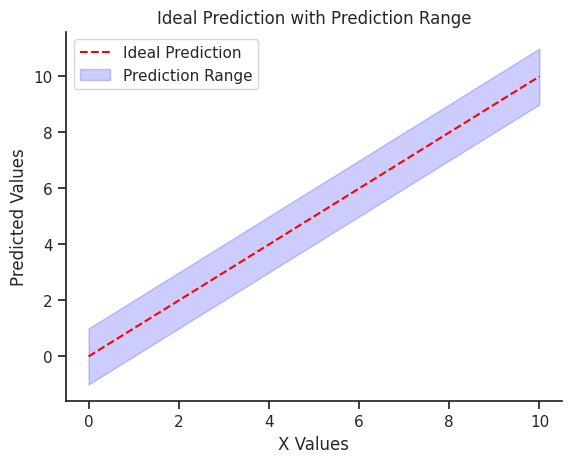

In [ ]:
# Создание данных для примера
x_values = np.linspace(0, 10, 100)
ideal_line = x_values  # Линия идеального предсказания
#Границей разброса может быть стандартное отклонение
lower_bound = ideal_line - 1  # Произвольная нижняя граница разброса
upper_bound = ideal_line + 1  # Произвольная верхняя граница разброса

# Создание графика
plt.plot(x_values, ideal_line, label='Ideal Prediction', linestyle='--', color='red')
plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2, label='Prediction Range')

# Добавление меток и легенды
plt.title('Ideal Prediction with Prediction Range')
plt.xlabel('X Values')
plt.ylabel('Predicted Values')
plt.legend()

# Отображение графика
plt.show()

Сначаала посмотрим на различие в предсказании этих двух моделей с помощью общего графика без линий разброса или линии идельного предсказания

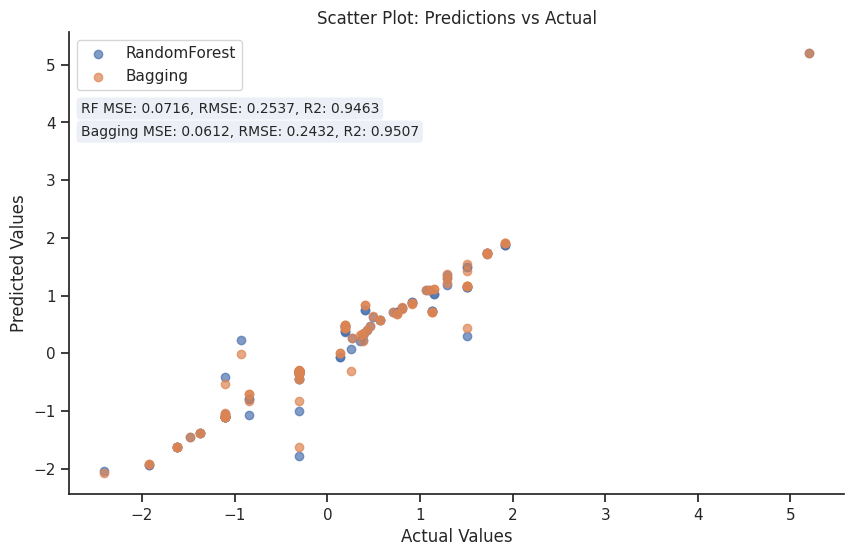

In [ ]:
# Создание графика
plt.figure(figsize=(10, 6))

# Scatter plot для RandomForest
plt.scatter(y_test, y_pred_rf, label='RandomForest', alpha=0.7)

# Scatter plot для Bagging
plt.scatter(y_test, y_pred_bagging, label='Bagging', alpha=0.7)

# Добавление меток и легенды
plt.title('Scatter Plot: Predictions vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Добавление текста с метриками в углу графика
text_rf = f'RF MSE: {mse_rf:.4f}, RMSE: {rmse_rf:.4f}, R2: {r2_rf:.4f}'
text_bagging = f'Bagging MSE: {mse_bagging:.4f}, RMSE: {rmse_bagging:.4f}, R2: {r2_bagging:.4f}'

plt.text(0.015, 0.85, text_rf, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))
plt.text(0.015, 0.80, text_bagging, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

# Отображение графика
plt.show()

Посчитаем стандартное отклонение моделей

In [ ]:
# Рассчитываем стандартное отклонение
std_rf = np.std(y_pred_rf)
std_bagging = np.std(y_pred_bagging)
print(f'RandomForest Std: {std_rf:.4f}')
print(f'Bagging Test Std: {std_bagging:.4f}')

RandomForest Std: 1.0512
Bagging Test Std: 1.0500


Сделаем отдельные графики для каждой модели, добавим линию идельного предсказания и разброса на основе отклонения от фактических и предсказанных

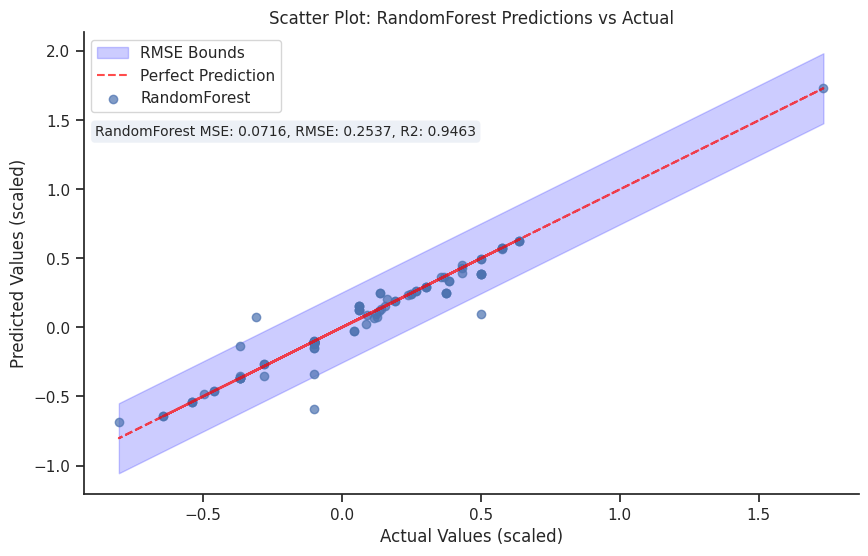

In [ ]:
# Scatter plot для RandomForest
text_rf = f'RandomForest MSE: {mse_rf:.4f}, RMSE: {rmse_rf:.4f}, R2: {r2_rf:.4f}'
plt.figure(figsize=(10, 6))

# Уменьшение масштаба по оси Y
y_test_scaled_rf = y_test / 3
y_pred_rf_scaled = y_pred_rf / 3

# Линия разброса от линии идеального предсказания
lower_bound_rf = np.sort(y_test_scaled_rf - rmse_rf)
upper_bound_rf = np.sort(y_test_scaled_rf + rmse_rf)
plt.fill_between(np.sort(y_test_scaled_rf), lower_bound_rf, upper_bound_rf, color='blue', alpha=0.2, label='RMSE Bounds')

# Идеальная линия предсказания
plt.plot(y_test_scaled_rf, y_test_scaled_rf, label='Perfect Prediction', linestyle='--', color='red', alpha=0.7)

# Точки предсказаний
plt.scatter(y_test_scaled_rf, y_pred_rf_scaled, label='RandomForest', alpha=0.7)

# Добавление текста с метриками
plt.text(0.015, 0.8, text_rf, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

plt.title('Scatter Plot: RandomForest Predictions vs Actual')
plt.xlabel('Actual Values (scaled)')
plt.ylabel('Predicted Values (scaled)')
plt.legend()
plt.show()

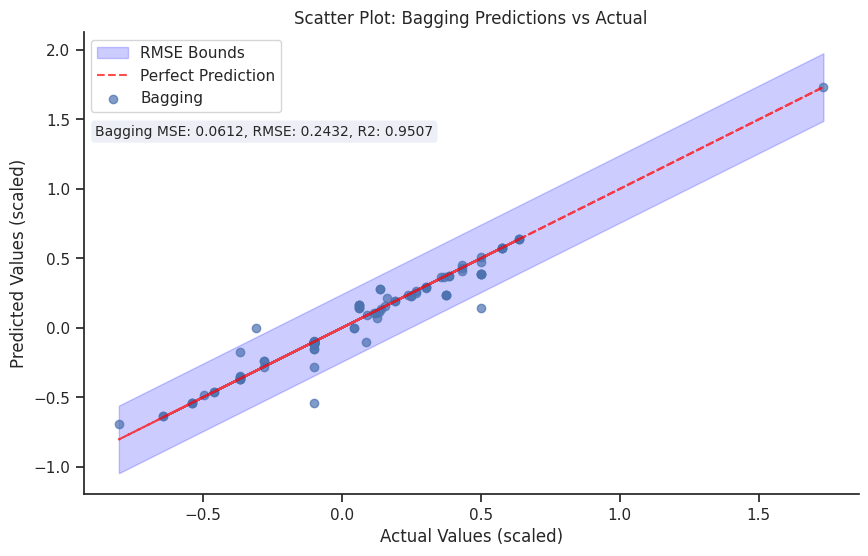

In [ ]:
# График рассеивания для Bagging
text_bagging = f'Bagging MSE: {mse_bagging:.4f}, RMSE: {rmse_bagging:.4f}, R2: {r2_bagging:.4f}'
plt.figure(figsize=(10, 6))

# Уменьшение масштаба по оси Y
y_test_scaled = y_test / 3
y_pred_bagging_scaled = y_pred_bagging / 3

# Линия разброса от линии идеального предсказания
lower_bound = np.sort(y_test_scaled - rmse_bagging)
upper_bound = np.sort(y_test_scaled + rmse_bagging)
plt.fill_between(np.sort(y_test_scaled), lower_bound, upper_bound, color='blue', alpha=0.2, label='RMSE Bounds')

# Идеальная линия предсказания
plt.plot(y_test_scaled, y_test_scaled, label='Perfect Prediction', linestyle='--', color='red', alpha=0.7)

# Точки предсказаний
plt.scatter(y_test_scaled, y_pred_bagging_scaled, label='Bagging', alpha=0.7)

# Добавление текста с метриками
plt.text(0.015, 0.8, text_bagging, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

plt.title('Scatter Plot: Bagging Predictions vs Actual')
plt.xlabel('Actual Values (scaled)')
plt.ylabel('Predicted Values (scaled)')
plt.legend()
plt.show()

# Проверим модели на переобучение

Посмотрим на производительность обучения и разницу визулизаций тестовой и тренировочной выборки

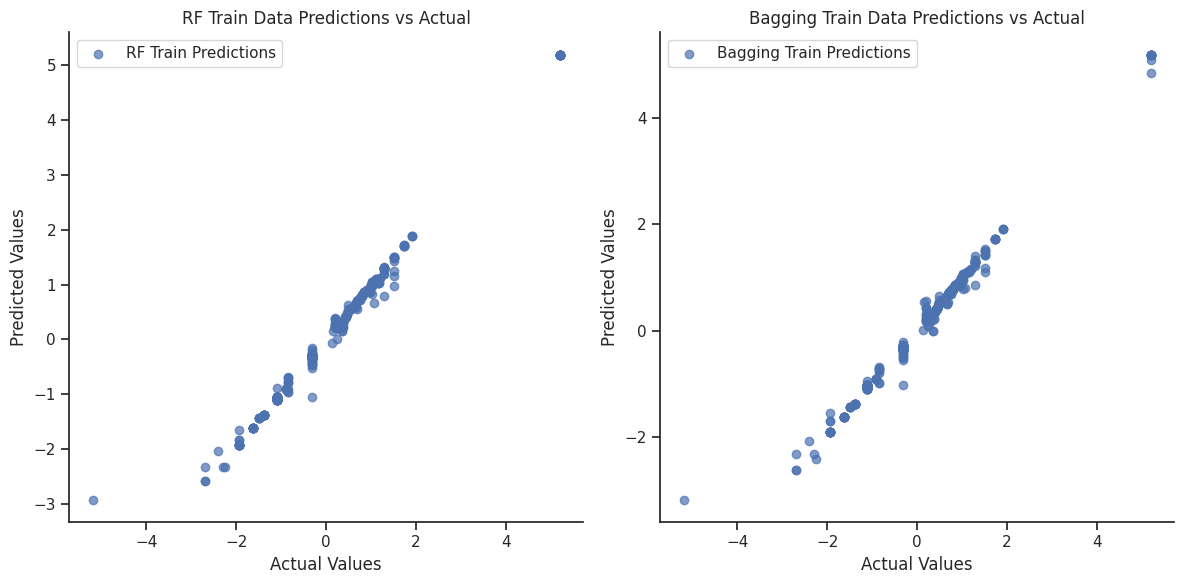

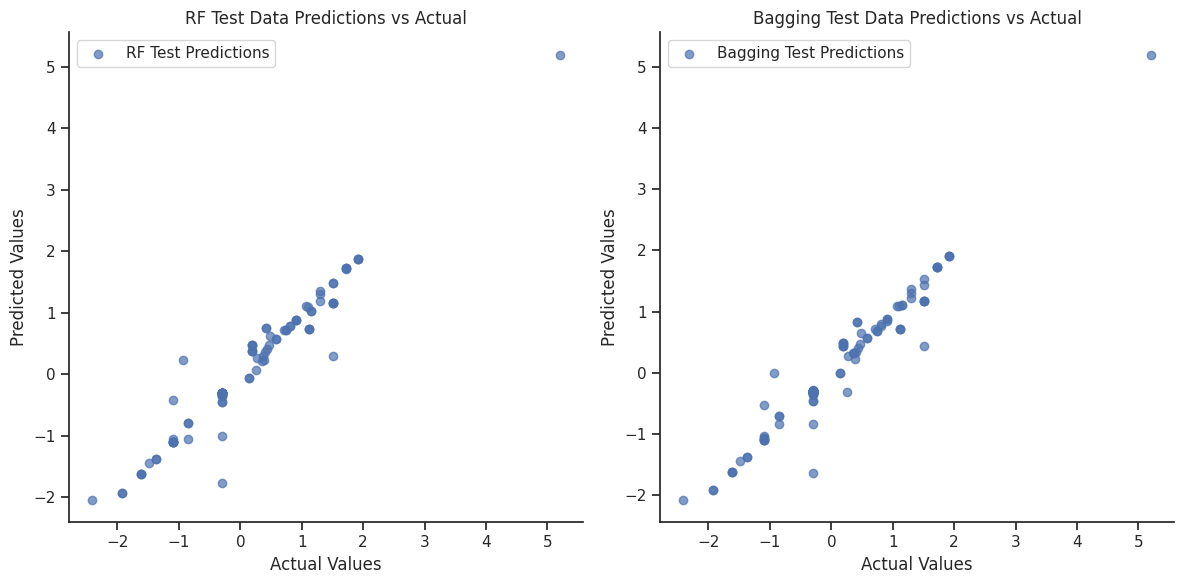

In [ ]:
# Для RandomForest
y_train_pred_rf = best_rf_model.predict(X_train)
y_test_pred_rf = best_rf_model.predict(X_test)

# Для Bagging
y_train_pred_bagging = best_bagging_model.predict(X_train)
y_test_pred_bagging = best_bagging_model.predict(X_test)

# Визуализация для тренировочных данных
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_rf, label='RF Train Predictions', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('RF Train Data Predictions vs Actual')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_train, y_train_pred_bagging, label='Bagging Train Predictions', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Bagging Train Data Predictions vs Actual')
plt.legend()

plt.tight_layout()
plt.show()

# Визуализация для тестовых данных
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_rf, label='RF Test Predictions', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('RF Test Data Predictions vs Actual')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_bagging, label='Bagging Test Predictions', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Bagging Test Data Predictions vs Actual')
plt.legend()

plt.tight_layout()
plt.show()

Как видно все предсказания на графиках выше похожи на диагональные прямые, это хороший знак. Как видно на в графиках test появляются выбросы в районе 0

In [ ]:
train_accuracy_rf = best_rf_model.score(X_train, y_train)
test_accuracy_rf = best_rf_model.score(X_test, y_test)

train_accuracy_bagging = best_bagging_model.score(X_train, y_train)
test_accuracy_bagging = best_bagging_model.score(X_test, y_test)

print(f'RF Train Accuracy: {train_accuracy_rf:.4f}, Test Accuracy: {test_accuracy_rf:.4f}')
print(f'Bagging Train Accuracy: {train_accuracy_bagging:.4f}, Test Accuracy: {test_accuracy_bagging:.4f}')

RF Train Accuracy: 0.9886, Test Accuracy: 0.9384
Bagging Train Accuracy: 0.9893, Test Accuracy: 0.9473


Оба метода (Random Forest и Bagging) показывают высокую точность как на обучающем, так и на тестовом наборе данных. Это обычно хороший знак, и может свидетельствовать о том, что модели хорошо обучены и обладают хорошей обобщающей способностью.
Bagging показывает чуть более высокую точность на тестовом наборе по сравнению с Random Forest. Это может свидетельствовать о том, что в данном случае Bagging работает чуть эффективнее

# Интерпретация

Еще раз обучим модели, чтобы иметь возможность обратиться именно к ним

In [ ]:
X = df.drop('Eff_anisotropy_const', axis=1)
y = df['Eff_anisotropy_const']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение RandomForest с заданными гиперпараметрами
rf_params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train, y_train)

# Обучение Bagging с заданными гиперпараметрами
bagging_params = {'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 50}
bagging_model = BaggingRegressor(**bagging_params)
bagging_model.fit(X_train, y_train)

# Предсказания на тестовом наборе
y_pred_rf = rf_model.predict(X_test)
y_pred_bagging = bagging_model.predict(X_test)

Посмотрим какие данные вносят больший вклад в предсказание с помощью SHAP диаграммы

  0%|          | 0/111 [00:00<?, ?it/s]

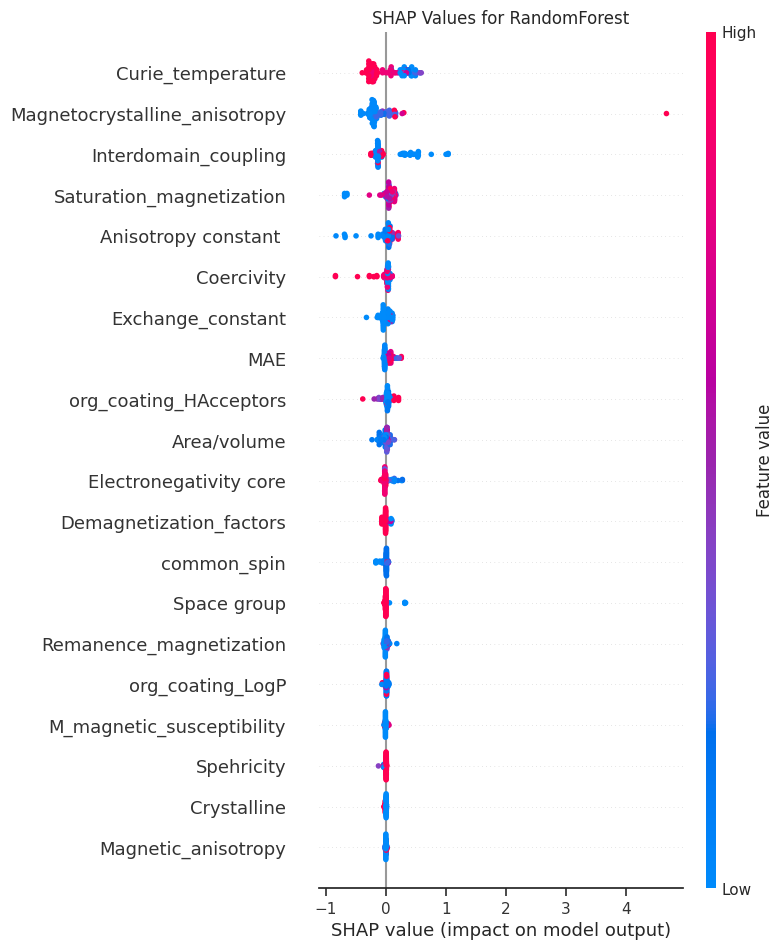

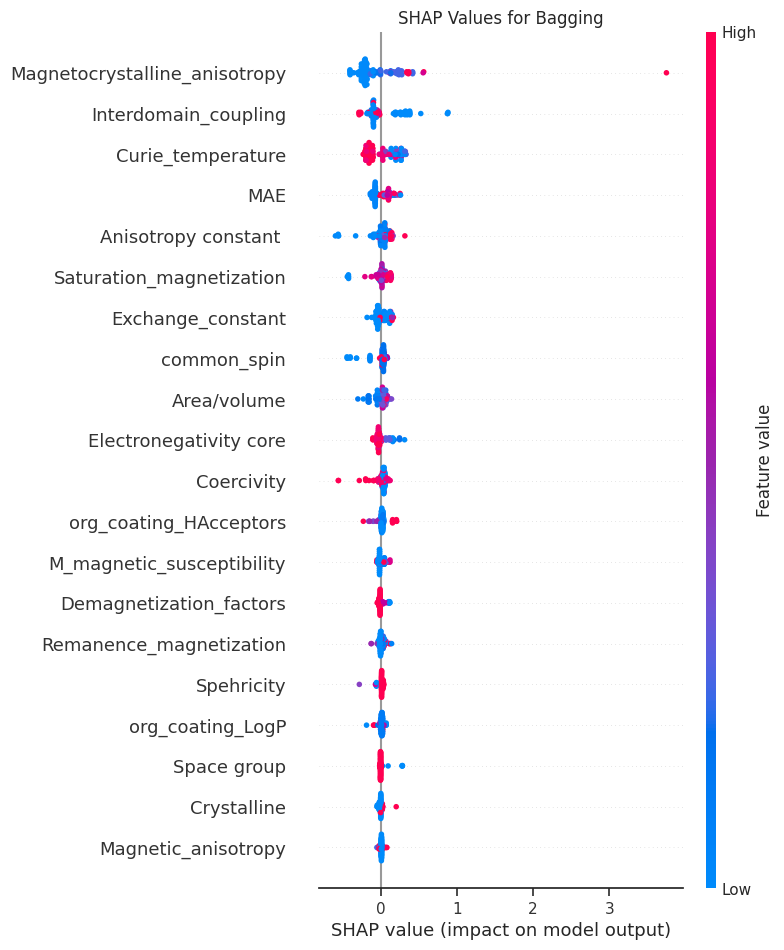

In [ ]:
import shap

# Создание explainer'ов
rf_explainer = shap.TreeExplainer(rf_model)

# Вместо TreeExplainer для Bagging используем KernelExplainer
bagging_explainer = shap.KernelExplainer(bagging_model.predict, X_train)

# Расчет SHAP-значений для тестового набора данных
shap_values_rf = rf_explainer.shap_values(X_test)
shap_values_bagging = bagging_explainer.shap_values(X_test)

# Построение SHAP-диаграммы для RandomForest
shap.summary_plot(shap_values_rf, X_test, feature_names=X_test.columns, show=False)
plt.title('SHAP Values for RandomForest')
plt.show()

# Построение SHAP-диаграммы для Bagging
shap.summary_plot(shap_values_bagging, X_test, feature_names=X_test.columns, show=False)
plt.title('SHAP Values for Bagging')
plt.show()